# Question 3 | ME7223 - End Semester Exam
## Quasi Newton Method
### Saarthak Marathe | ME17B162

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from sympy.solvers import solve
from sympy import *

In [2]:
#roll no is ME17B162
a = 162/17
b = 6
c = 9
d = 5
e = 1

In [74]:
def f(x):
    return (x[0]**2+x[1]-b)**2+(x[0]+x[1]**2-e)**2

#defining the gradient of the objective function
def gradf(x):
    fx1 = 2*(x[0]**2+x[1]-b)*(2*x[0]) + 2*(x[0]+x[1]**2-e)
    fx2 = 2*(x[0]**2+x[1]-b) + 2*(x[0]+x[1]**2-e)*(2*x[1])
    return np.array([fx1,fx2])
    
#norm taking function
def norm(x):
    return math.sqrt(x[0]**2 + x[1]**2)

#normalizing any vector: x_normalized = x/||x||
def normalize(x):
    return (x / math.sqrt(x[0]**2 + x[1]**2))


#calculation of the lambda step for each iteration
'''
Conditions are used below to check the positive definiteness of hessian matrix. This is important to find out 
which lambda_step needs to be chosen as we may get multiple values given that gradf(x) function is a quadratic function.

The steps for this are mentioned below:
Find all lambda values
Calculate Hessian for all f(x) corresponding to these lambda values
Check which hessians are positive definite
if there is only one solution: 
    print that
else:
    find the hessian giving highest value and take lambda corresponding to this value
'''
def lambda_calc(x,l):
    sol = solve(diff(f(x)), l) #find the lambda for which grad_f goes to zero
    sol = np.array([float(re(i)) for i in sol])
    hess = diff(diff(f(x)))  #calculation of hessian values
    hes_vals = np.array([float(hess.evalf(subs={l: i})) for i in sol]) #calculating hessian of all possible points corresponding to the lambda
    
    if len(sol) == 1: #return if only one lambda value is found
        return sol
   
    #for multiple lambda points 
    candidates = [i for i in range(len(sol)) if hes_vals[i] > 0] #Keeping the points only with hessian definite positive
    hes_vals = [hes_vals[i] for i in candidates]
    
    try:
        return sol[candidates[np.argmax(hes_vals)]] #finding lambda with best hessian
    except:
        return 'None'

In [75]:
'''
We use Rank 2 updates for this Quasi Newton method (BFGS). Here the B values are defined based on the BFGS method

Algorithm:
input starting point
define the terminating condition
loop (maxiters and tolerance condition):
    if i==1:
        B_initial = identity matrix
        S = -B.grad(f)
        calculate lambda value
        x = x_old+lambda*S
        carry forward the B,S,x values
        error calculation
    else:
        define g = gradf(x_new) - gradf(x_old)
        Calculate B_new using BFGS method: B_new = B_old+M+N
        S = -B_new.gradf(x_new)
        calculate lambda value
        x_old = x_new
        x_new = x_old+lambda*S
        carry forward the B,S,x values
        error calculation
'''

def quasi_newton(x0):
    x0 = np.asarray(x0)
    
    #initializing count, error and terminating conditions
    i = 0
    maxiter = 10
    tol = 1e-03
    error = norm(gradf(x0))
    
    lmb = symbols("lambda")  #for the calculation of lambda values. defining the variable
    
    points = [x0]   #for storing all the points visited
    
    print('Count - ', i, ' - x values:', x0,' - f(x) value:', f(x0))
    
    #while loop with tolerance and max iterations terminating conditions
    while error > tol and i<maxiter:
        
        i=i+1
        
        if i == 1:
            B = np.eye(2)  #initializing B as identity matrix
            S = -B@gradf(x0) # S = -B.grad(f(x))
            S = normalize(S) #normalizing S
            
            x_symb = x0 + lmb*S #calculating lambda value
            lmb_step = lambda_calc(x_symb,lmb)
            x = x0 + lmb_step*S
            
            print('Count - ', i, ' - x values:', x,' - f(x) value:', f(x))
        
            #storing the current values for further use
            prev_x = x0
            prev_B = B
            prev_S = S
            prev_grad = gradf(prev_x)
            points.append(x)
            error = norm(gradf(x)) #error = ||grad(f(x))||
            
        else:
            grad = gradf(x)
            g = grad - prev_grad  #defining g as difference between grad at current - prev point
            M = lmb_step*(prev_S@prev_S.T)/(prev_S.T@g+1e-04)
            N = -(prev_B@g)@(g.T@prev_B)/(g.T@prev_B@g+1e-04)
            B = prev_B + M + N  #establishing new B value based on BFGS method
            
            S = -B@grad  #subtituting new B value and calcuating S
            S = normalize(S)
            
            x_symb = prev_x + lmb*S #calculating lambda value
            lmb_step = lambda_calc(x_symb,lmb)
            x = prev_x + lmb_step*S
            
            print('Count - ', i, ' - x values:', x,' - f(x) value:', f(x))
            
            error = norm(grad)
            prev_x = x
            prev_S = S
            prev_B = B
            prev_grad = gradf(prev_x)
            points.append(x)

    return x, f(x), i, np.array(points)

In [76]:
def plot(points, f):
    #establishing the boundaries
    x = np.linspace(-3, 3, 1000)
    y = np.linspace(-3, 3, 1000)
    
    #contour plotting
    xx, yy = np.meshgrid(x, y)
    zz = np.array([f(a) for a in np.c_[xx.ravel(), yy.ravel()]])
    zz = zz.reshape(xx.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, zz)
    plt.colorbar()
    
    #points visited plotting
    plt.plot(points[:, 0], points[:, 1], color='w', linewidth=2)
    plt.scatter(points[:, 0], points[:, 1], c='w', s=40, edgecolor='w')
    plt.text(points[0][0]-0.1, points[0][1]+0.1, 'start', color='w', fontsize=12, fontweight='bold') #start point
    plt.text(points[-1][0]+0.1, points[-1][1]-0.10, 'end', color='w', fontsize=12, fontweight='bold') #end point
    plt.axvline(points[-1][0], ymin=0, ymax=1, color='w', linewidth=1)
    plt.axhline(points[-1][1], xmin=0, xmax=1, color='w', linewidth=1)
    plt.grid()
    plt.title('Trajectory of Quasi Newton Method from (' + str(points[0]) + ')')
    plt.show()

Count -  0  - x values: [2 0]  - f(x) value: 5
Count -  1  - x values: [2.36728779 0.10493937]  - f(x) value: 1.9843973841801845
Count -  2  - x values: [ 2.40527053 -0.12574244]  - f(x) value: 2.1353562982604424
Count -  3  - x values: [ 2.42999847 -0.10101756]  - f(x) value: 2.1126497525393844
Count -  4  - x values: [ 2.40122713 -0.0931324 ]  - f(x) value: 2.0949066496036326
Count -  5  - x values: [ 2.42159146 -0.07277076]  - f(x) value: 2.079547957629937
Count -  6  - x values: [ 2.39767052 -0.06693898]  - f(x) value: 2.0672255875050713
Count -  7  - x values: [ 2.41474458 -0.04986731]  - f(x) value: 2.0564513052761524
Count -  8  - x values: [ 2.39454778 -0.04546133]  - f(x) value: 2.047628068049142
Count -  9  - x values: [ 2.40906405 -0.03094719]  - f(x) value: 2.0398528964252205
Count -  10  - x values: [ 2.39180183 -0.02756045]  - f(x) value: 2.0333807950404177


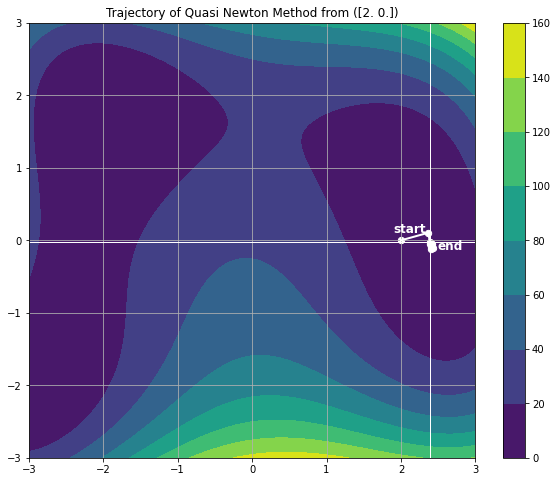

In [77]:
opt, optval, count, points = quasi_newton([2,0])
plot(points, f)

Count -  0  - x values: [1 0]  - f(x) value: 25
Count -  1  - x values: [-2.81773956 -1.90886978]  - f(x) value: 0.031208398945188974
Count -  2  - x values: [-2.18492539  1.17622188]  - f(x) value: 3.2476288985401087
Count -  3  - x values: [-1.87990797  1.48123516]  - f(x) value: 1.4400462336610198
Count -  4  - x values: [-2.10808209  1.55346657]  - f(x) value: 0.4827863647010972
Count -  5  - x values: [-1.99928499  1.6622621 ]  - f(x) value: 0.17178274314770867
Count -  6  - x values: [-2.07718959  1.68544223]  - f(x) value: 0.05592001793953319
Count -  7  - x values: [-2.04118161  1.72144968]  - f(x) value: 0.018624372728152743
Count -  8  - x values: [-2.06669838  1.72888105]  - f(x) value: 0.006032440469181651
Count -  9  - x values: [-2.05498122  1.74059804]  - f(x) value: 0.0019689796424841987
Count -  10  - x values: [-2.06326277  1.7429929 ]  - f(x) value: 0.0006369858453886348


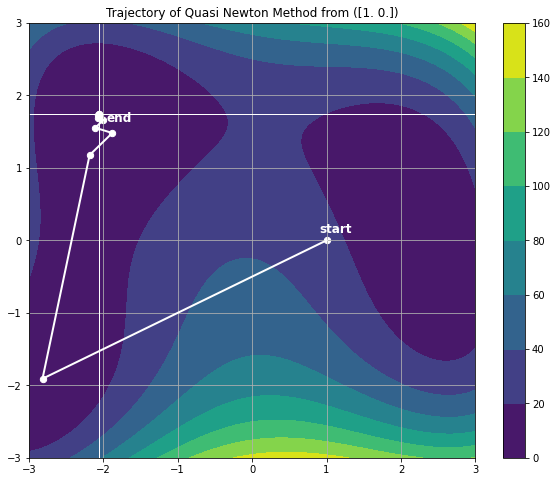

In [78]:
opt, optval, count, points = quasi_newton([1,0])
plot(points, f)

Count -  0  - x values: [0 0]  - f(x) value: 37
Count -  1  - x values: [0.25068233 1.50409397]  - f(x) value: 21.94117147996892
Count -  2  - x values: [-0.53691579  1.77352945]  - f(x) value: 18.096599174597763
Count -  3  - x values: [-2.12087004  0.18952945]  - f(x) value: 11.239251473537283
Count -  4  - x values: [-1.99096452  1.74508205]  - f(x) value: 0.08762190388479761
Count -  5  - x values: [-2.03009448  1.70595027]  - f(x) value: 0.04420692457945764
Count -  6  - x values: [-2.02623607  1.7468948 ]  - f(x) value: 0.022393593491935634
Count -  7  - x values: [-2.04557092  1.72755904]  - f(x) value: 0.011492704797271606
Count -  8  - x values: [-2.04352133  1.74815271]  - f(x) value: 0.0059125996693637755
Count -  9  - x values: [-2.05334163  1.73833194]  - f(x) value: 0.003061271991295152
Count -  10  - x values: [-2.05226283  1.74888669]  - f(x) value: 0.0015871145127719954


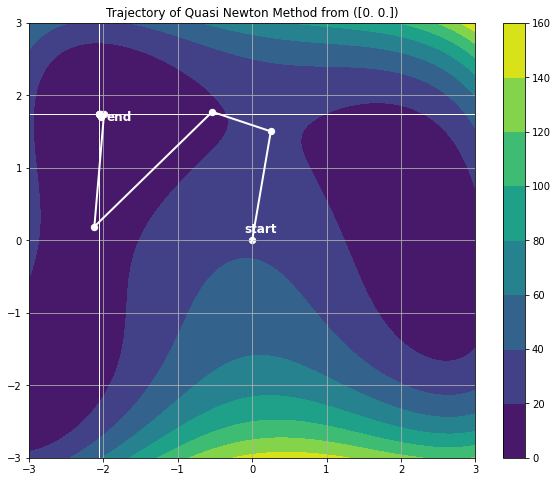

In [79]:
opt, optval, count, points = quasi_newton([0,0])
plot(points, f)

Count -  0  - x values: [-1 -1]  - f(x) value: 37
Count -  1  - x values: [-2.38021392 -0.49810403]  - f(x) value: 10.503455365885474
Count -  2  - x values: [-2.74050542 -1.5292913 ]  - f(x) value: 1.9653270426617107
Count -  3  - x values: [-2.86441989 -1.65319301]  - f(x) value: 1.584386365656044
Count -  4  - x values: [-2.76492871 -1.61884606]  - f(x) value: 1.3100202022998975
Count -  5  - x values: [-2.86151142 -1.71541827]  - f(x) value: 1.0678557962140438
Count -  6  - x values: [-2.78089647 -1.68514019]  - f(x) value: 0.8881831494390976
Count -  7  - x values: [-2.85746344 -1.76169846]  - f(x) value: 0.7310686240254688
Count -  8  - x values: [-2.79162577 -1.73545058]  - f(x) value: 0.6114778815506916
Count -  9  - x values: [-2.85321565 -1.79703321]  - f(x) value: 0.5074381173104862
Count -  10  - x values: [-2.7990231  -1.77445402]  - f(x) value: 0.42654609495353285


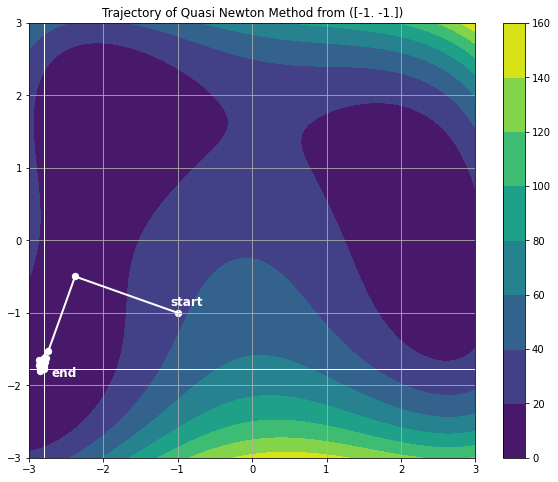

In [80]:
opt, optval, count, points = quasi_newton([-1,-1])
plot(points, f)

Count -  0  - x values: [ 2 -1]  - f(x) value: 13
Count -  1  - x values: [ 2.5608258  -0.60742194]  - f(x) value: 3.7265381699271583
Count -  2  - x values: [-1.99700187  1.8555477 ]  - f(x) value: 0.22343758072344064
Count -  3  - x values: [-2.07899268  1.77355661]  - f(x) value: 0.013594975868377778
Count -  4  - x values: [-2.05708133  1.75802884]  - f(x) value: 0.0012357913646240182
Count -  5  - x values: [-2.06319205  1.7519181 ]  - f(x) value: 0.0001116346983216189
Count -  6  - x values: [-2.061201    1.75050796]  - f(x) value: 1.0356910483489579e-05
Count -  7  - x values: [-2.06176057  1.74994839]  - f(x) value: 9.603346492623966e-07
Count -  8  - x values: [-2.06157585  1.74981757]  - f(x) value: 8.92619722715537e-08
Count -  9  - x values: [-2.0616278   1.74976562]  - f(x) value: 8.296373304420531e-09
Count -  10  - x values: [-2.06161063  1.74975347]  - f(x) value: 7.712689771352992e-10


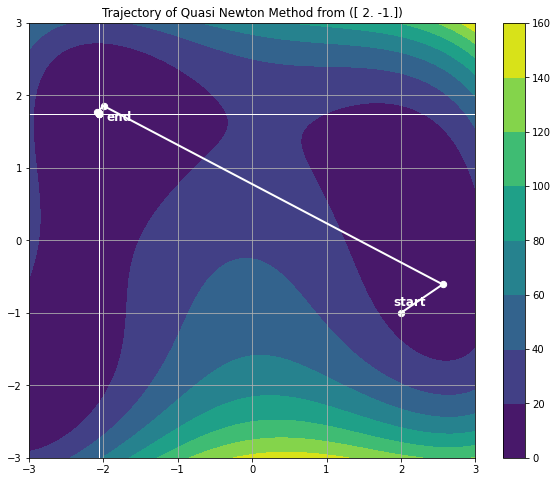

In [81]:
opt, optval, count, points = quasi_newton([2,-1])
plot(points, f)